# Export Signals

In [9]:
# Load and plot the 12 time series in the first entry of dataframe_lfp
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:

with open('dataframe_lfp.pkl', 'rb') as f:
    df = pickle.load(f)

first_lfp = np.array(df['lfp_data'][0])
print('Shape of first lfp_data entry:', first_lfp.shape)



Shape of first lfp_data entry: (149999, 12)


In [11]:
# Inspect the type and keys/shape
print('Type:', type(df))
if isinstance(df, dict):
    print('Keys:', df.keys())
elif isinstance(df, np.ndarray):
    print('Shape:', df.shape)
elif isinstance(df, pd.DataFrame):
    print('Columns:', df.columns)
else:
    print('Unknown structure:', df)

Type: <class 'pandas.core.frame.DataFrame'>
Columns: Index(['acronym', 'lfp_data', 'overlapping_acronyms'], dtype='object')


In [12]:
def plot_lfp_seconds(lfp, region_labels=None, sfreq=2500, title=None, figsize=(20, 10),
                     fontsize=12, legend_loc='upper right', save_name=None): 
    """
    Plot multichannel LFP time series with x-axis in seconds.
    - lfp: array-like, shape either (n_channels, n_samples) or (n_samples, n_channels)
    - region_labels: list/array of channel names (length n_channels)
    - sfreq: sampling frequency in Hz (default 2500)
    - save_name: optional string filename to save the figure (e.g. 'plot.png'); default None (no save)
    """
    if save_name is not None and not isinstance(save_name, str):
        raise TypeError("save_name must be a string filename or None")

    lfp = np.array(lfp)
    if lfp.ndim == 1:
        # single channel vector: make it (n_samples, 1)
        lfp = lfp[:, None]

    # If rows correspond to channels, transpose to shape (n_samples, n_channels)
    if region_labels is not None and lfp.shape[0] == len(region_labels) and lfp.shape[1] != len(region_labels):
        lfp = lfp.T
    elif region_labels is None and lfp.shape[0] < lfp.shape[1]:
        # heuristic: if fewer rows than columns, assume rows are channels -> transpose
        lfp = lfp.T

    n_time, n_channels = lfp.shape
    time = np.arange(n_time) / float(sfreq)

    plt.figure(figsize=figsize)
    for ch in range(n_channels):
        label = (region_labels[ch] if region_labels is not None and ch < len(region_labels) else None)
        plt.plot(time, lfp[:, ch], label=label)

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    if title:
        plt.title(title)
    if region_labels is not None:
        plt.legend(loc=legend_loc, fontsize=fontsize, bbox_to_anchor=(1, 1))
    plt.tight_layout()

    if save_name:
        plt.savefig(save_name, dpi=300, bbox_inches='tight')

    plt.show()
    return plt.gcf()


In [40]:
def compute_and_plot_fcd(entry_idx, df, sfreq=2500, win_sec=5, step_sec=1,
                         min_win_sec=0.5, cmap='plasma', symmetric_scale=False,
                         save_name=None, verbose=True):
    """
    Compute sliding-window FC and plot the Functional Connectivity Dynamics (FCD) heatmap.

    Parameters
    - entry_idx: int, index into df['lfp_data'] and df['acronym'] (0-based)
    - df: dataframe/dict-like object containing 'lfp_data' and 'acronym'
    - sfreq: sampling frequency in Hz
    - win_sec: desired window length in seconds
    - step_sec: sliding step in seconds
    - min_win_sec: minimum allowed window (seconds) when auto-adjusting
    - cmap: matplotlib colormap name for the heatmap
    - symmetric_scale: if True, scale colorbar symmetrically around 0 using max(abs(min),abs(max))
    - save_name: optional filename (string) to save the figure as PNG (dpi=300). If provided without extension, '.png' will be appended.
    - verbose: if True, print diagnostics

    Returns a dict with keys: fcd_matrix, time_axis, fc_windows, win_centers_sec, vmin, vmax
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import zscore
    from scipy.interpolate import interp1d

    # params -> samples
    window_size = int(win_sec * sfreq)
    step_size = int(step_sec * sfreq)
    min_window_samples = int(min_win_sec * sfreq)

    # load
    lfp = np.array(df['lfp_data'][entry_idx])
    region_labels = df['acronym'][entry_idx] if isinstance(df['acronym'][entry_idx], (list, tuple, np.ndarray)) else [df['acronym'][entry_idx]]

    # ensure orientation: want (n_channels, n_samples)
    if lfp.ndim == 1:
        lfp = lfp[None, :]
    if lfp.shape[0] == len(region_labels) and lfp.shape[1] != len(region_labels):
        # rows are channels -> keep
        pass
    elif lfp.shape[1] == len(region_labels) and lfp.shape[0] != len(region_labels):
        lfp = lfp.T
    else:
        if lfp.shape[0] > lfp.shape[1]:
            pass
        else:
            lfp = lfp.T

    n_channels, n_samples = lfp.shape
    if verbose:
        print(f'Entry {entry_idx}: LFP shape (channels x samples): {n_channels} x {n_samples}')
        expected = sfreq * 60
        print(f'Expected samples for 60s at {sfreq} Hz: {expected} (actual: {n_samples})')

    # NaN handling: report then attempt interpolation per channel
    nan_counts = np.isnan(lfp).sum(axis=1)
    if verbose:
        print('NaN counts per channel (first 10):', nan_counts[:10])
    if nan_counts.max() > 0:
        if verbose:
            print('Attempting simple 1D interpolation for channels with NaNs...')
        for ch in range(n_channels):
            ch_data = lfp[ch].astype(float)
            if np.isnan(ch_data).any():
                good = ~np.isnan(ch_data)
                if good.sum() < 2:
                    # not enough points to interpolate
                    continue
                f = interp1d(np.where(good)[0], ch_data[good], kind='linear', bounds_error=False, fill_value='extrapolate')
                lfp[ch] = f(np.arange(n_samples))
        nan_counts_after = np.isnan(lfp).sum(axis=1)
        if verbose:
            print('NaN counts after interpolation (first 10):', nan_counts_after[:10])

    # adjust window if needed
    if window_size > n_samples:
        if verbose:
            print(f'Warning: requested window_size={window_size} > n_samples={n_samples}. Adjusting window size.')
        window_size = max(min_window_samples, n_samples // 2)
        step_size = max(1, min(step_size, window_size // 2))
        if verbose:
            print(f'New window_size={window_size} samples ({window_size/sfreq:.3f}s), step_size={step_size} samples ({step_size/sfreq:.3f}s)')

    # sliding windows
    fc_windows = []
    win_centers_sec = []
    for start in range(0, n_samples - window_size + 1, step_size):
        stop = start + window_size
        win = lfp[:, start:stop]  # (n_channels, window_size)
        with np.errstate(invalid='ignore'):
            win_z = zscore(win, axis=1, ddof=0)
        if np.isnan(win_z).any():
            continue
        if np.isfinite(win_z).sum() == 0:
            continue
        try:
            fc = np.corrcoef(win_z)
        except Exception:
            continue
        fc_windows.append(fc)
        win_centers_sec.append((start + stop) / 2.0 / sfreq)

    fc_windows = np.array(fc_windows)
    n_windows = fc_windows.shape[0] if fc_windows.size else 0
    if verbose:
        print(f'Computed {n_windows} FC windows')

    if n_windows == 0:
        if verbose:
            print('No valid windows for FCD. Suggestions: reduce win_sec or step_sec, or check for channels with constant values / many NaNs.')
        return dict(fcd_matrix=None, time_axis=None, fc_windows=fc_windows, win_centers_sec=win_centers_sec, vmin=None, vmax=None)

    # vectorize upper triangle
    triu_idx = np.triu_indices(n_channels, k=1)
    fc_vecs = np.array([fw[triu_idx] for fw in fc_windows])

    if fc_vecs.shape[0] == 1:
        fcd_matrix = np.array([[1.0]])
        time_axis = np.array(win_centers_sec)
    else:
        with np.errstate(invalid='ignore'):
            fcd_matrix = np.corrcoef(fc_vecs)
        time_axis = np.array(win_centers_sec)

    # color scale
    vmin = np.nanmin(fcd_matrix)
    vmax = np.nanmax(fcd_matrix)
    if not np.isfinite(vmin) or not np.isfinite(vmax):
        vmin, vmax = -1.0, 1.0
    elif np.isclose(vmin, vmax):
        eps = max(1e-6, abs(vmin) * 1e-3)
        vmin -= eps
        vmax += eps
    if symmetric_scale:
        m = max(abs(vmin), abs(vmax))
        vmin, vmax = -m, m

    # plot
    fig, ax = plt.subplots(figsize=(8, 6))
    extent = [time_axis[0], time_axis[-1], time_axis[0], time_axis[-1]]
    im = ax.imshow(fcd_matrix, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower', extent=extent, aspect='auto')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('FC similarity (Pearson r)')
    ax.set_xlabel('Window center time (s)')
    ax.set_ylabel('Window center time (s)')
    # invert y-axis so time 0 is at the top (upper-left corner of the heatmap)
    ax.invert_yaxis()
    ax.set_title(f'FCD gridplot (entry {entry_idx}) — win={win_sec}s step={step_sec}s — n_windows={n_windows}\n(vmin={vmin:.3g}, vmax={vmax:.3g})')
    plt.tight_layout()

    # save if requested
    if save_name is not None:
        if not isinstance(save_name, str):
            raise TypeError('save_name must be a string filename or None')
        fname = save_name if os.path.splitext(save_name)[1].lower() == '.png' else save_name + '.png'
        fig.savefig(fname, dpi=300, bbox_inches='tight')
        if verbose:
            print(f'Saved FCD figure to {fname}')

    if show := True:
        plt.show()

    return dict(fcd_matrix=fcd_matrix, time_axis=time_axis, fc_windows=fc_windows, win_centers_sec=win_centers_sec, vmin=vmin, vmax=vmax)


# Example usage (uncomment to run):
# res = compute_and_plot_fcd(4, df)   # entry 5
# res = compute_and_plot_fcd(9, df)   # entry 10
# res = compute_and_plot_fcd(21, df)  # entry 22
# To change window/step: compute_and_plot_fcd(4, df, win_sec=3, step_sec=0.5, symmetric_scale=True)


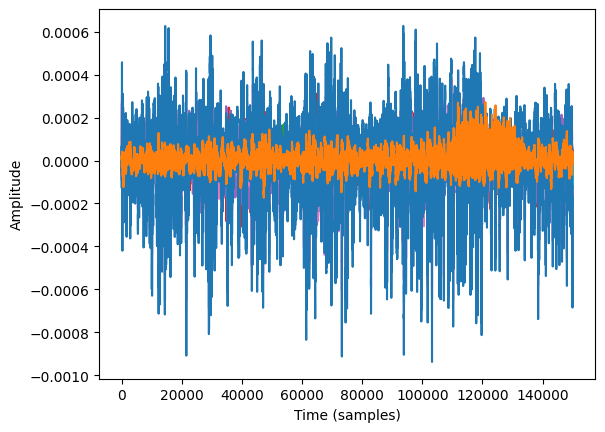

In [13]:
plt.plot(first_lfp)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
#plt.legend()
plt.show()

In [14]:
first_lfp = np.array(df['lfp_data'][0])
labels = df['acronym'][0] if isinstance(df['acronym'][0], (list, tuple, np.ndarray)) else [df['acronym'][0]]

print('Shape of first lfp_data entry:', first_lfp.shape)
print('Region labels:', labels)


Shape of first lfp_data entry: (149999, 12)
Region labels: ['SSp-bfd' 'CP' 'SSp-un' 'GPe' 'SSp-n' 'PH' 'DG' 'PAG' 'PF' 'LH' 'CA1'
 'SUM']


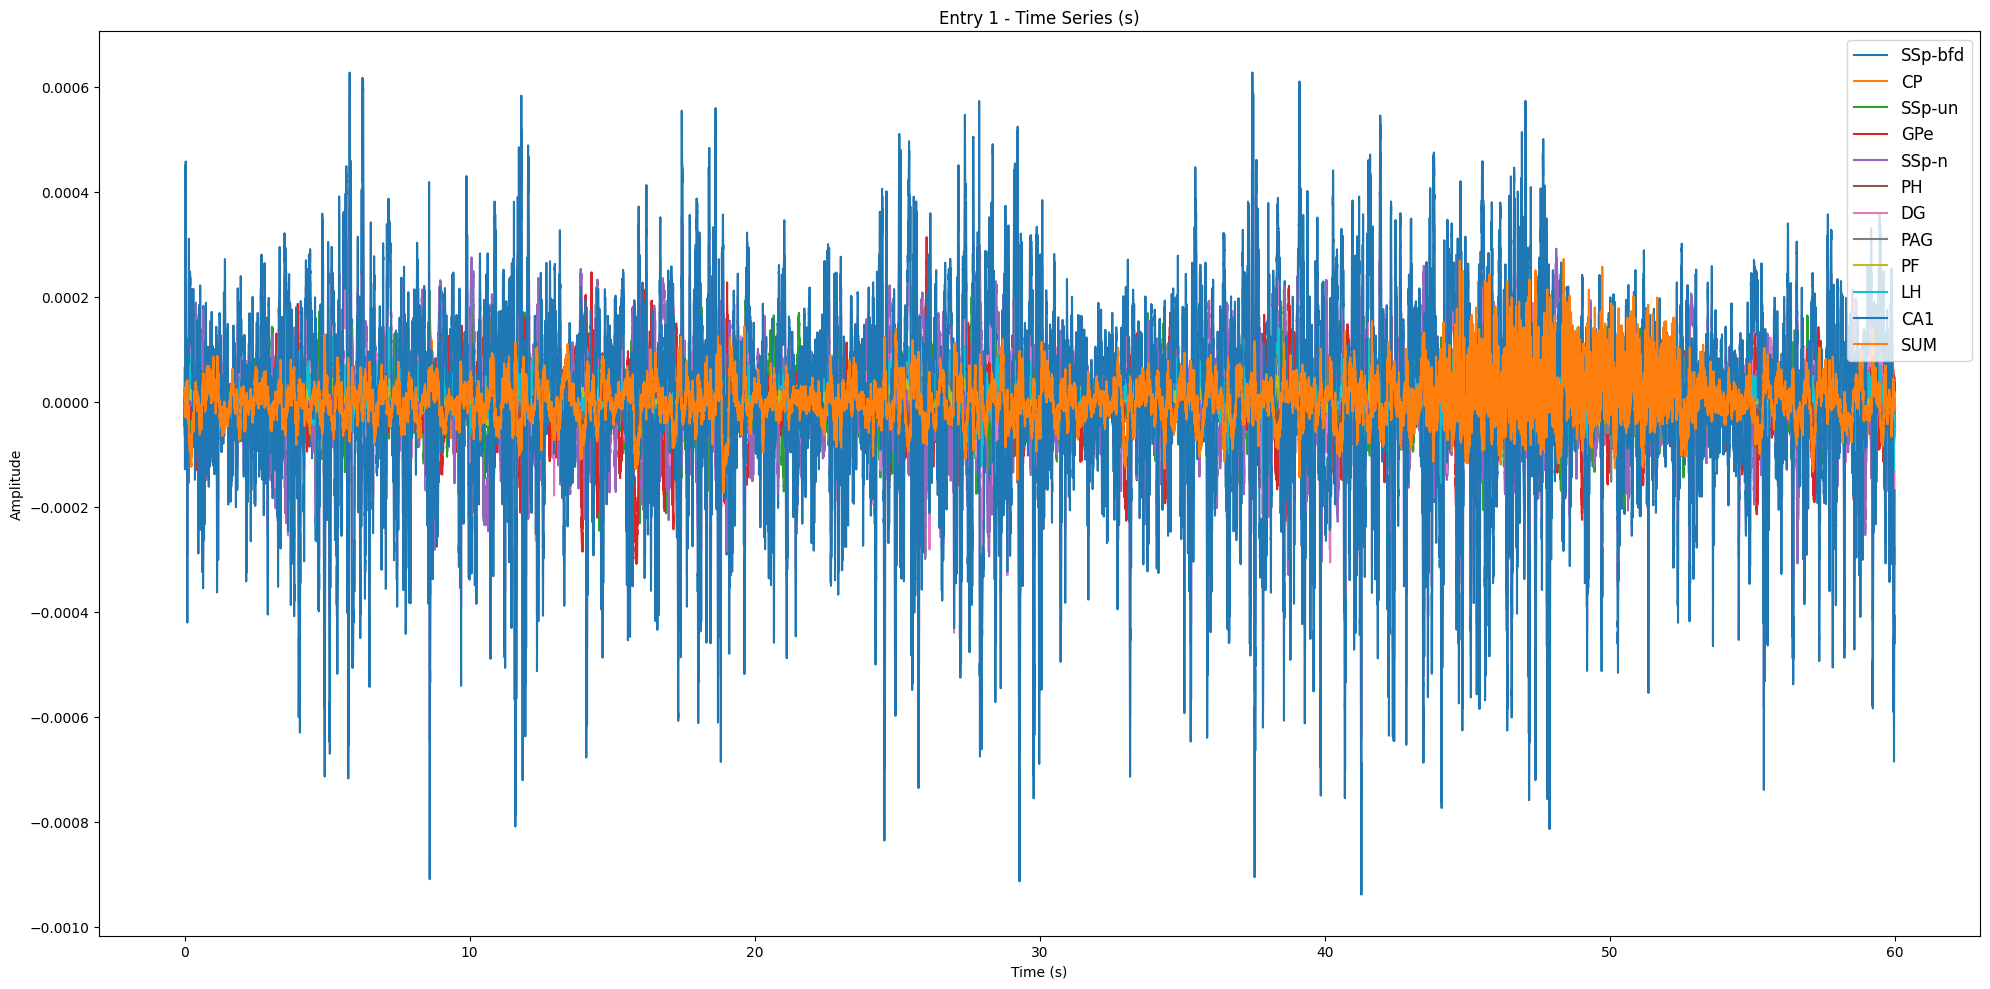

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
# Examples: redraw some previously plotted entries with x-axis in seconds
# Entry 1 (first_lfp / region_labels)
plot_lfp_seconds(first_lfp, region_labels=labels, sfreq=2500, title='Entry 1 - Time Series (s)')

# Acronyms

In [16]:
# Analyze and output all unique acronym combinations present in the dataframe, prioritizing MOp and MOs
def get_acronym_combinations(acronym_col):
    combos = []
    for entry in acronym_col:
        if isinstance(entry, (list, tuple, np.ndarray)):
            combos.append(tuple(sorted([str(a) for a in entry])))
        else:
            combos.append((str(entry),))
    return combos

acronym_combos = get_acronym_combinations(df['acronym'])
unique_combos = list(set(acronym_combos))

# Sort combos: first those containing 'MOp', then 'MOs', then the rest
def combo_priority(combo):
    combo_str = ' '.join(combo)
    if any('MOp' in c for c in combo):
        return (0, combo_str)
    elif any('MOs' in c for c in combo):
        return (1, combo_str)
    else:
        return (2, combo_str)

unique_combos_sorted = sorted(unique_combos, key=combo_priority)
print('Unique acronym combinations present in the dataframe (MOp/MOs prioritized):')
for combo in unique_combos_sorted:
    print(combo)

Unique acronym combinations present in the dataframe (MOp/MOs prioritized):
('ACAv', 'ACB', 'CP', 'DG', 'LH', 'MD', 'MOp', 'RSPv', 'SMT')
('ACB', 'BMA', 'CA3', 'COAp', 'CP', 'MOp')
('ACB', 'CP', 'LSc', 'MOp', 'MOs', 'SF', 'SI')
('ACB', 'CP', 'MOp', 'MOs')
('AHN', 'AM', 'AV', 'MOp', 'VM', 'VMH', 'ZI')
('AM', 'AV', 'BST', 'CP', 'LPO', 'MOp', 'NDB', 'SI')
('AM', 'BST', 'CP', 'LHA', 'MOp', 'RT', 'SF', 'ZI')
('AN', 'CP', 'MOp', 'MOs')
('AV', 'BST', 'CP', 'MOp', 'MRN', 'PAG', 'PRNr', 'SSp-ll')
('BST', 'CP', 'EPd', 'LSv', 'MOp', 'MOs', 'MPO')
('BST', 'CP', 'LSv', 'MOp')
('BST', 'CP', 'MEA', 'MOp', 'RT')
('BST', 'CP', 'MOp')
('CA1', 'CP', 'DG', 'EPd', 'LP', 'MOp', 'PIR', 'PO', 'SI')
('CP', 'MOp', 'RSPd', 'RSPv', 'SSp-m')
('ACAd', 'BLA', 'CEA', 'CP', 'GPe', 'LSr', 'MOs', 'PAA', 'PL')
('ACB', 'APN', 'CA1', 'CP', 'DG', 'MOs', 'MRN', 'SNr')
('BLA', 'CA3', 'CEA', 'CP', 'GPe')
('BLA', 'CEA', 'CP', 'GPe', 'PIR')
('CA1', 'CP', 'DG', 'GPe', 'LH', 'PAG', 'PF', 'PH', 'SSp-bfd', 'SSp-n', 'SSp-un', 'SUM')


# Second PLotting

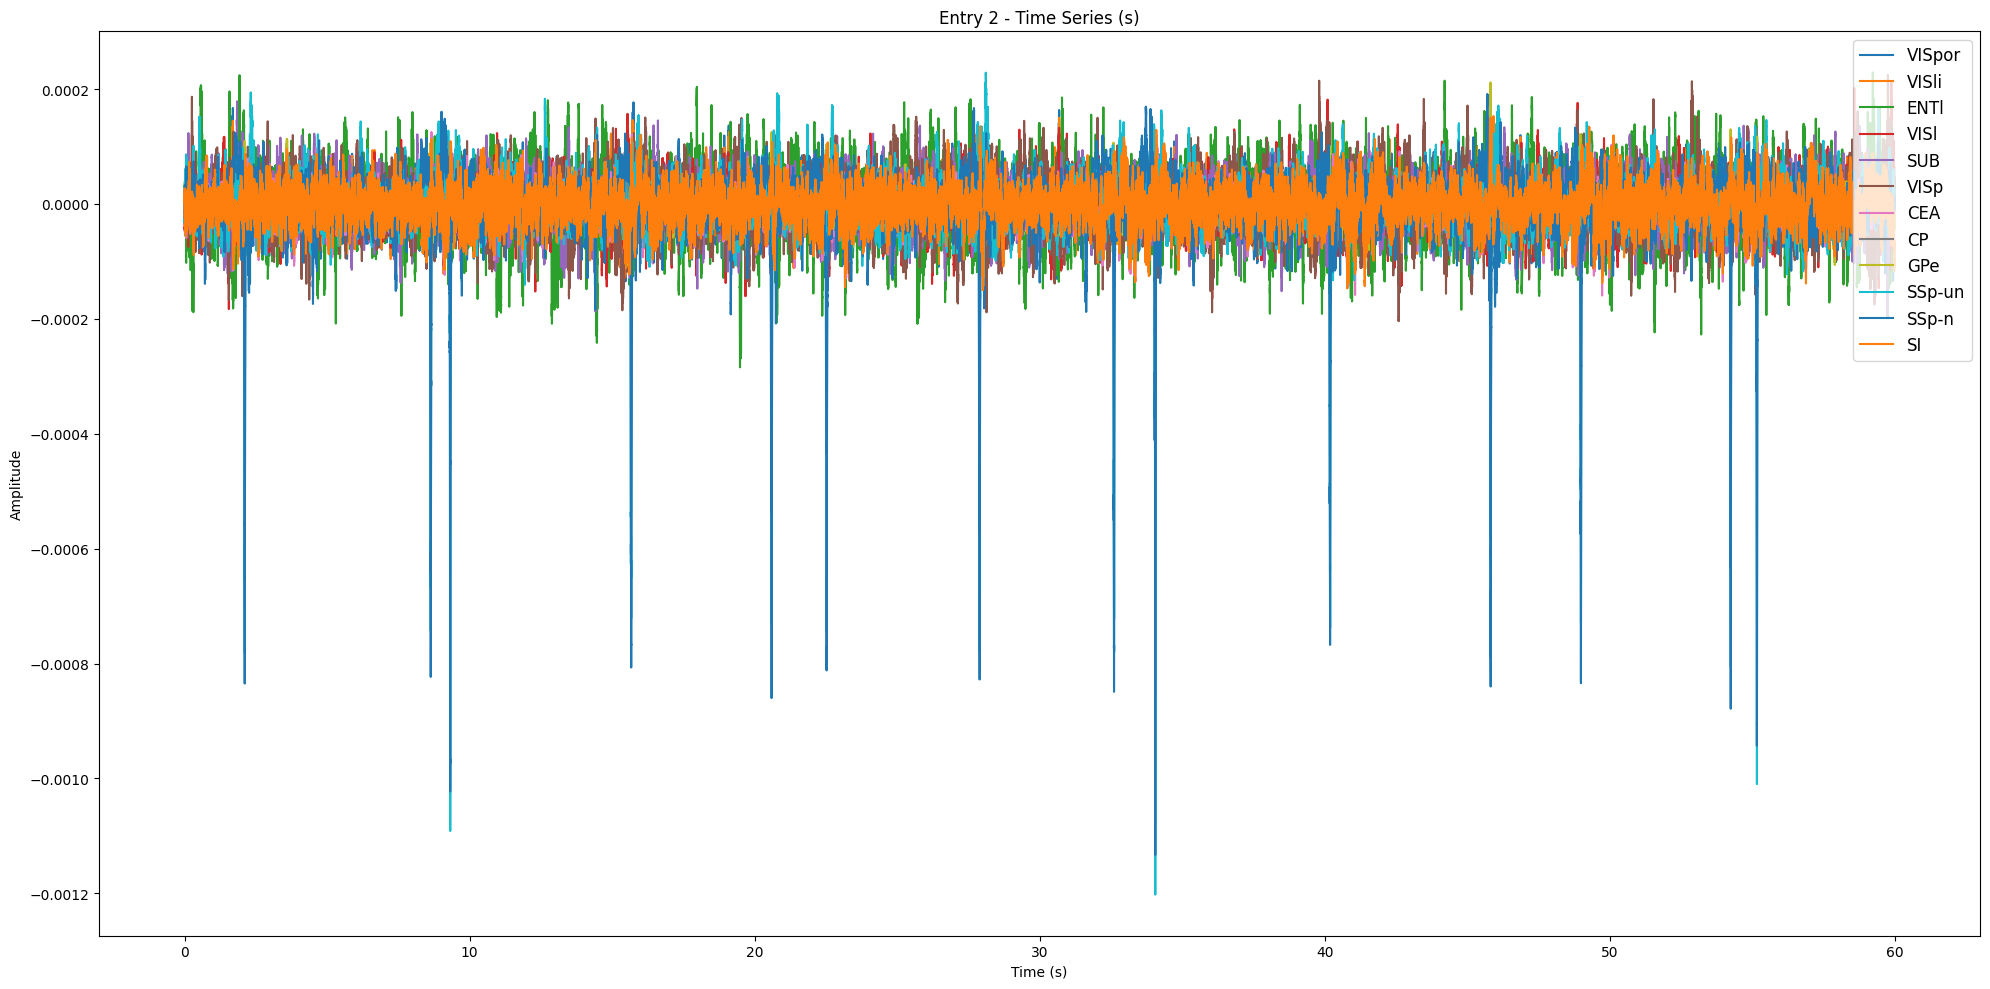

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
# Entry 2 (second_lfp / region_labels_2)
# Plot the time series for the second entry using its region labels
second_lfp = np.array(df['lfp_data'][1])
region_labels_2 = df['acronym'][1] if isinstance(df['acronym'][1], (list, tuple, np.ndarray)) else [df['acronym'][1]]

plot_lfp_seconds(second_lfp, region_labels=region_labels_2, sfreq=2500, title='Entry 2 - Time Series (s)')
#plot_lfp_seconds(second_lfp, region_labels=region_labels_2, sfreq=2500, title='Entry 2 - Time Series (s)', save_name='Second_lfp_time_series.png')

# All Plots

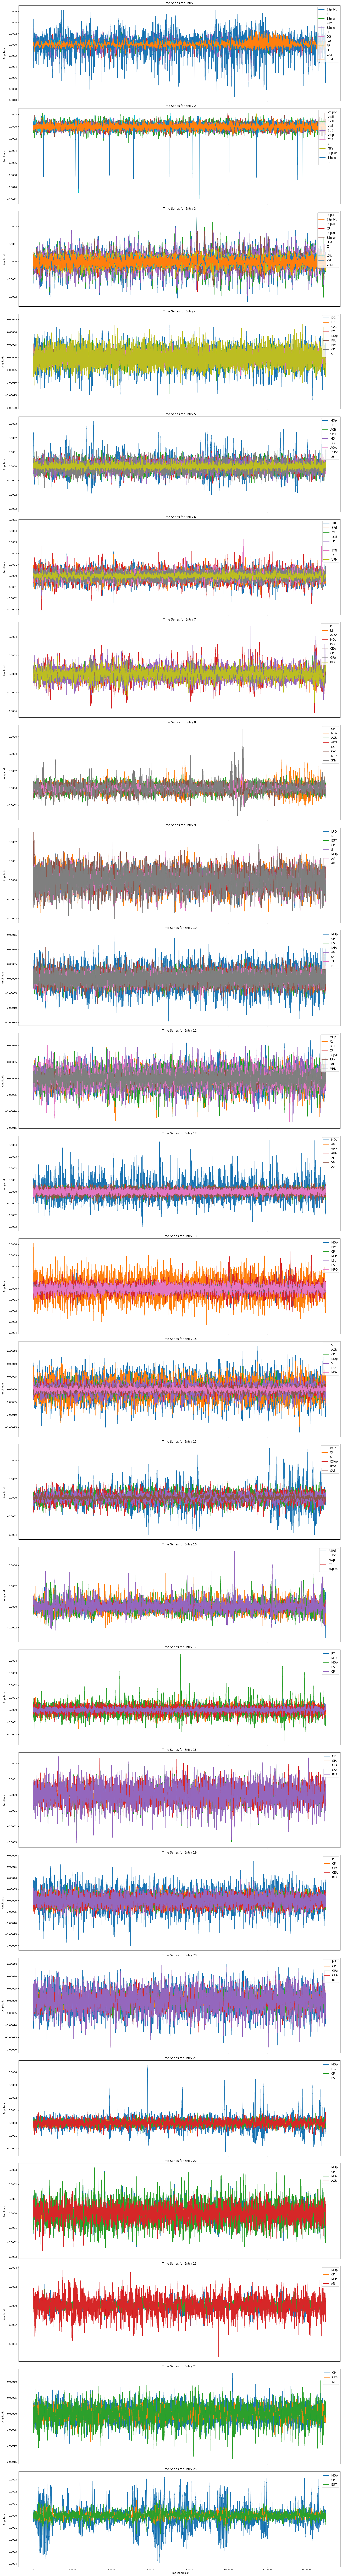

In [18]:
# Plot all available subsets in the dataframe as subplots, each with its region labels
num_entries = len(df['lfp_data'])
fig, axes = plt.subplots(num_entries, 1, figsize=(20, 6 * num_entries), sharex=True)
if num_entries == 1:
    axes = [axes]
for idx in range(num_entries):
    lfp = np.array(df['lfp_data'][idx])
    region_labels = df['acronym'][idx] if isinstance(df['acronym'][idx], (list, tuple, np.ndarray)) else [df['acronym'][idx]]
    axes[idx].plot(lfp, label=region_labels)
    axes[idx].set_ylabel('Amplitude')
    axes[idx].legend(region_labels, loc='upper right', bbox_to_anchor=(1, 1), fontsize=12)
    axes[idx].set_title(f'Time Series for Entry {idx+1}')
axes[-1].set_xlabel('Time (samples)')
plt.tight_layout()
#plt.savefig('All_lfp_time_series.png', dpi = 300)
plt.show()

# FC Matrix

## One Dataset Containing MOP
### Entry 5: MOP and CP

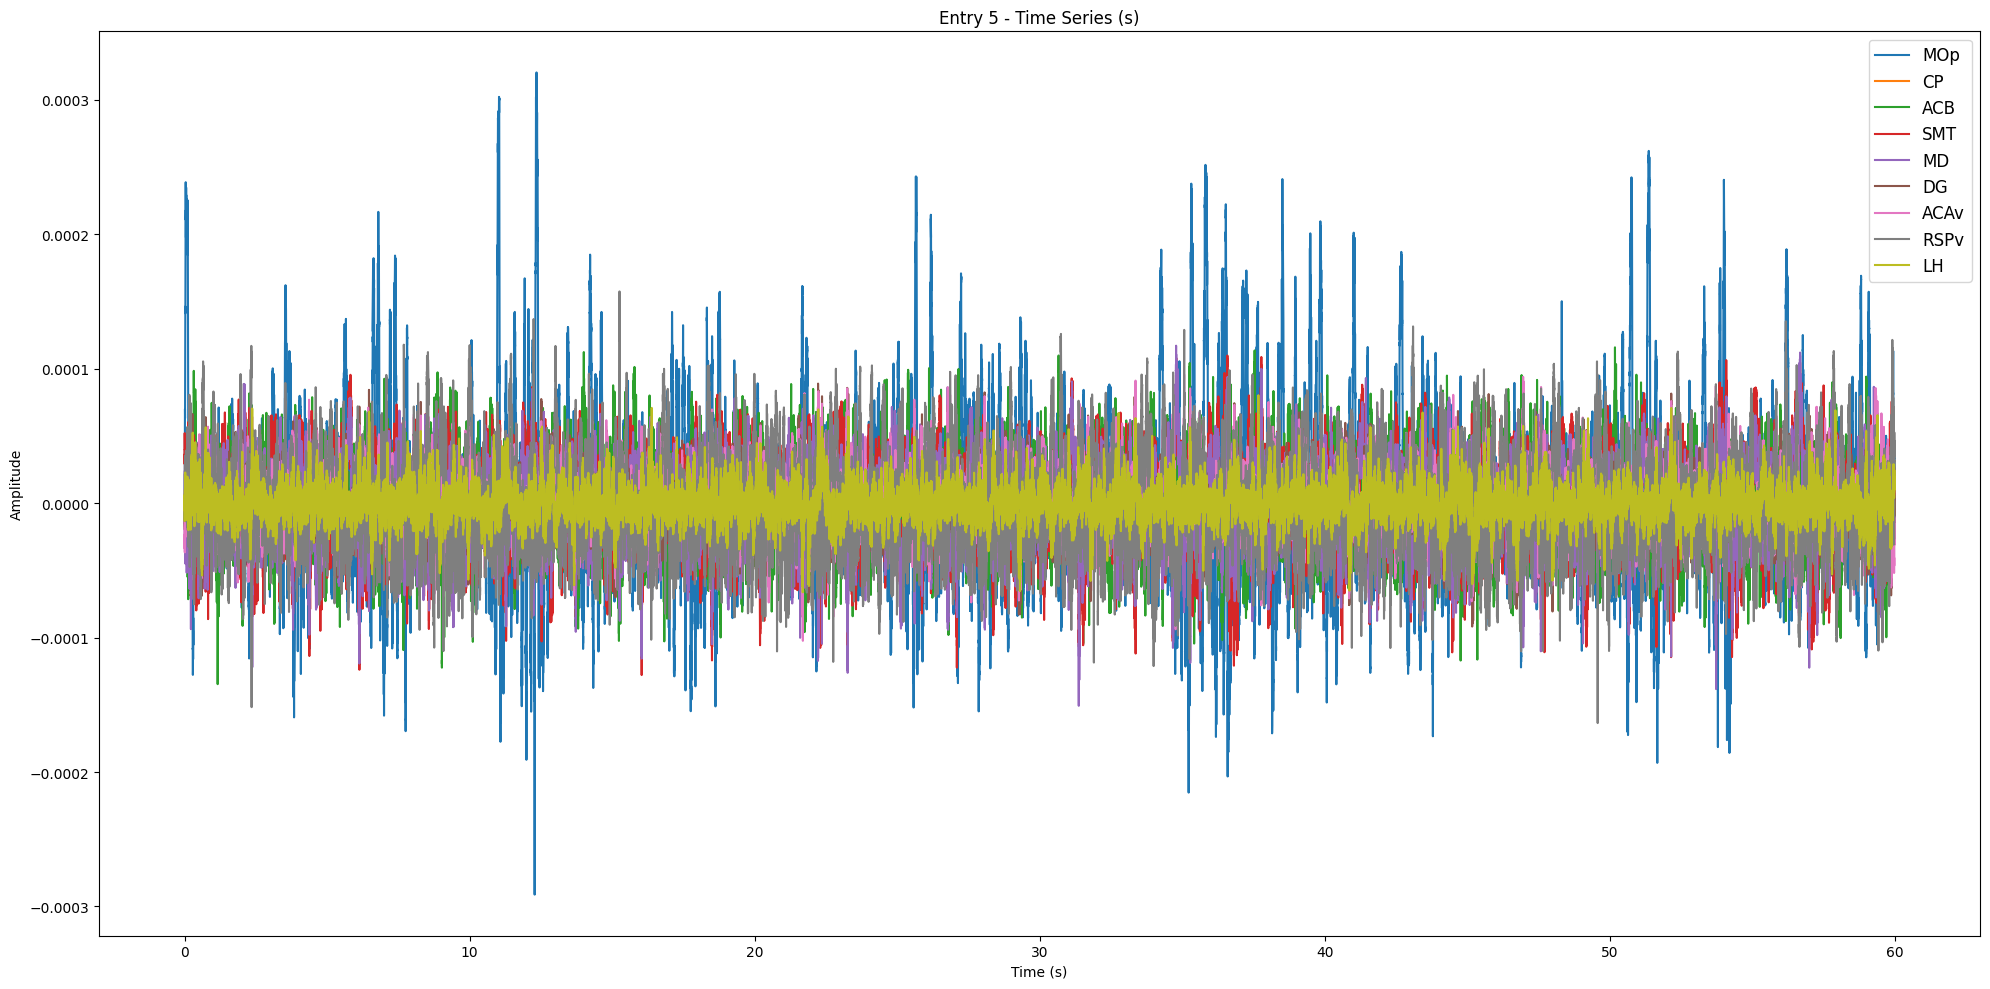

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
# Entry 5 (fifth_lfp / region_labels_5)
# Plot the time series for the fifth entry using its region labels
fifth_lfp = np.array(df['lfp_data'][4])
region_labels_5 = df['acronym'][4] if isinstance(df['acronym'][4], (list, tuple, np.ndarray)) else [df['acronym'][4]]

#plot_lfp_seconds(fifth_lfp, region_labels=region_labels_5, sfreq=2500, title='Entry 5 - Time Series (s)', save_name="Fifth_lfp_time_series.png")
plot_lfp_seconds(fifth_lfp, region_labels=region_labels_5, sfreq=2500, title='Entry 5 - Time Series (s)')

FC matrix shape: (9, 9)


MOp        CP       ACB       SMT        MD        DG      ACAv  \
MOp   1.000000 -0.715626 -0.453212  0.053747 -0.022298 -0.019433  0.036667   
CP   -0.715626  1.000000  0.591388 -0.052112  0.003218  0.048147 -0.034538   
ACB  -0.453212  0.591388  1.000000  0.025606  0.053910 -0.025862 -0.107216   
SMT   0.053747 -0.052112  0.025606  1.000000  0.736795 -0.749586 -0.667149   
MD   -0.022298  0.003218  0.053910  0.736795  1.000000 -0.842395 -0.766975   
DG   -0.019433  0.048147 -0.025862 -0.749586 -0.842395  1.000000  0.768515   
ACAv  0.036667 -0.034538 -0.107216 -0.667149 -0.766975  0.768515  1.000000   
RSPv  0.099118 -0.125000 -0.134385 -0.336553 -0.407406  0.221072  0.620721   
LH   -0.092223  0.120895  0.081440 -0.503491 -0.417485  0.605293  0.293987   

          RSPv        LH  
MOp   0.099118 -0.092223  
CP   -0.125000  0.120895  
ACB  -0.134385  0.081440  
SMT  -0.336553 -0.503491  
MD   -0.407406 -0.417485  
DG    0.221072  0.605293  
ACAv  0.620721  0.293987  
RSPv  1.000000 -0.159767  
LH   -0.159767  1.000000

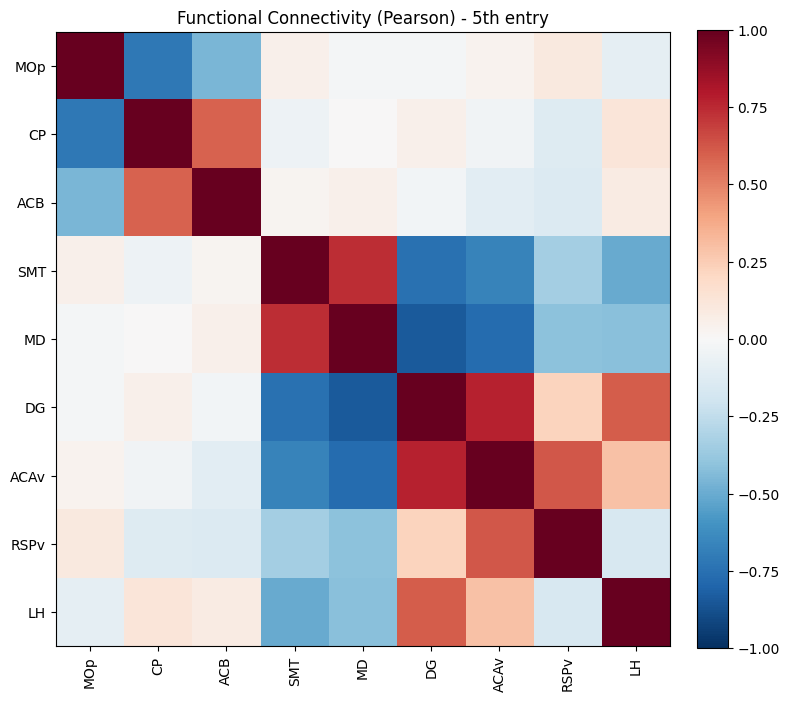

In [20]:
# Calculate Pearson FC matrix from fifth_lfp (structure: time x regions)
labels = list(region_labels_5)
lfp = np.array(fifth_lfp)  # ensure ndarray

# Ensure orientation: want shape (timepoints, n_regions)
if lfp.ndim != 2:
    raise ValueError(f"Expected 2D array for fifth_lfp, got shape {lfp.shape}")
# If rows correspond to regions, transpose
if lfp.shape[0] == len(labels) and lfp.shape[1] != len(labels):
    lfp = lfp.T
elif lfp.shape[1] != len(labels):
    raise ValueError(f"Mismatch between lfp shape {lfp.shape} and number of labels {len(labels)}")

# Pearson correlation across regions
fc = np.corrcoef(lfp, rowvar=False)
fc_df = pd.DataFrame(fc, index=labels, columns=labels)

print('FC matrix shape:', fc_df.shape)
display(fc_df)

# Plot heatmap
plt.figure(figsize=(8, 8))
im = plt.imshow(fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Functional Connectivity (Pearson) - 5th entry')
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.savefig('Fifth_lfp_FC_matrix.png', dpi=300)
plt.show()

## FC-Dynamics Fifth Entry

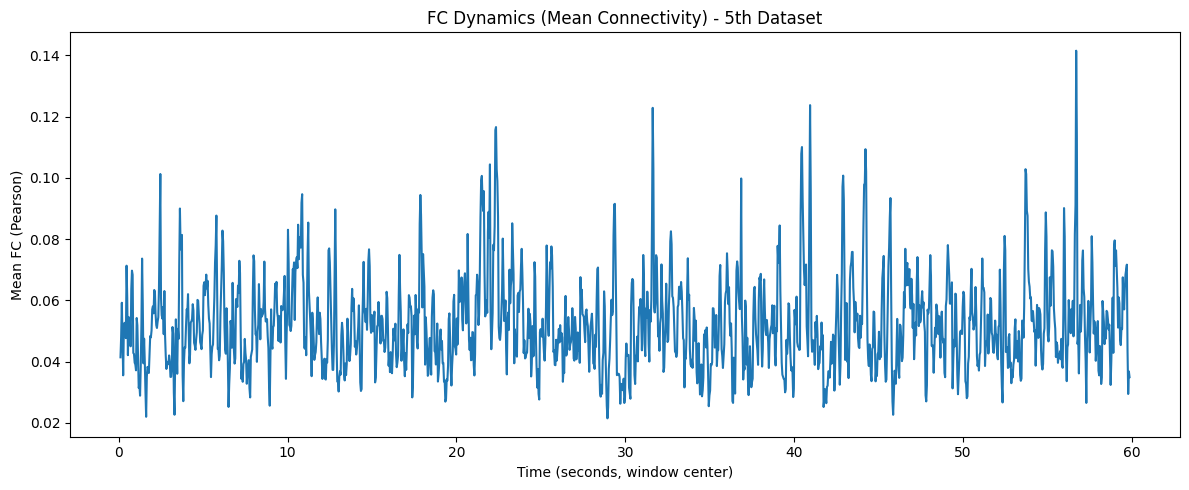

In [21]:
# Calculate and plot FC dynamics for the fifth dataset (entry 5) with x-axis in seconds (2500 Hz sampling frequency)
from scipy.stats import zscore
window_size = 500  # samples per window (adjust as needed)
step_size = 100    # step between windows
sfreq = 2500  # Hz
lfp = np.array(df['lfp_data'][4])
region_labels = df['acronym'][4] if isinstance(df['acronym'][4], (list, tuple, np.ndarray)) else [df['acronym'][4]]

# Ensure orientation: shape (timepoints, n_regions)
if lfp.shape[0] == len(region_labels) and lfp.shape[1] != len(region_labels):
    lfp = lfp.T
n_time, n_regions = lfp.shape

fc_dyn = []
win_centers = []
for start in range(0, n_time - window_size + 1, step_size):
    win = lfp[start:start+window_size, :]
    win_z = zscore(win, axis=0)
    fc_win = np.corrcoef(win_z, rowvar=False)
    fc_dyn.append(fc_win)
    win_centers.append(start + window_size // 2)

fc_dyn = np.array(fc_dyn)  # shape: (n_windows, n_regions, n_regions)

# Convert window centers to seconds for x-axis
win_centers_sec = [center / sfreq for center in win_centers]

# Plot FC dynamics (mean connectivity over time)
mean_fc = fc_dyn.mean(axis=(1,2))
plt.figure(figsize=(12, 5))
plt.plot(win_centers_sec, mean_fc)
plt.xlabel('Time (seconds, window center)')
plt.ylabel('Mean FC (Pearson)')
plt.title('FC Dynamics (Mean Connectivity) - 5th Dataset')
plt.tight_layout()

#plt.savefig("Fifth_lfp_FCD_timesies.png", dpi = 300)
plt.show()

# FCD Matrix Plot

Entry 4: LFP shape (channels x samples): 9 x 149999
Expected samples for 60s at 2500 Hz: 150000 (actual: 149999)
NaN counts per channel (first 10): [0 0 0 0 0 0 0 0 0]
Computed 55 FC windows


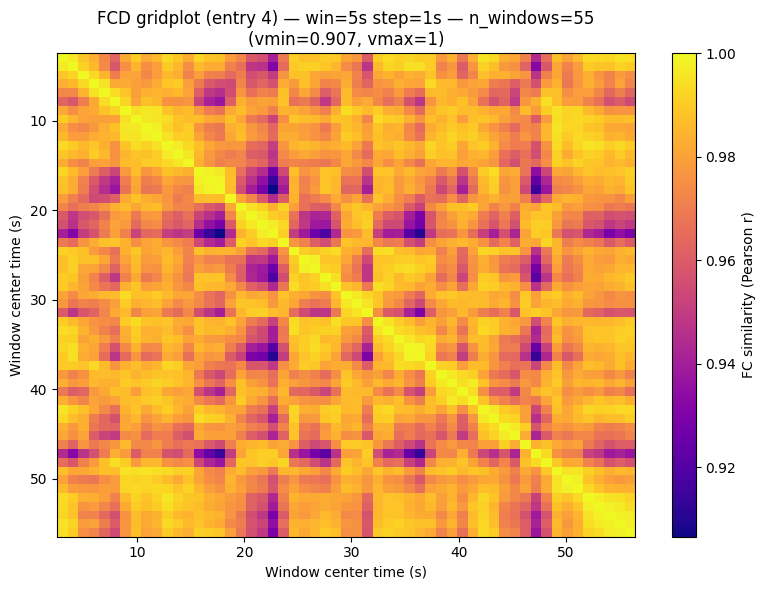


FCD matrix shape: (55, 55)
vmin: 0.9065206861678, vmax: 1.0
Number of windows: 55


In [43]:
# Apply the compute_and_plot_fcd function to the 5th dataset (index 4)
# This will compute sliding-window FC, show the FCD heatmap, and return results in res_entry5
#res_entry5 = compute_and_plot_fcd(4, df, sfreq=2500, win_sec=5, step_sec=1, symmetric_scale=False, verbose=True, save_name="Fifth_lfp_FCD_matrix.png")
res_entry5 = compute_and_plot_fcd(4, df, sfreq=2500, win_sec=5, step_sec=1, symmetric_scale=False, verbose=True)


# Summary of results
if res_entry5.get('fcd_matrix') is None:
    print('\nNo FCD matrix produced for entry 5. See diagnostics above.')
else:
    fcd = res_entry5['fcd_matrix']
    print(f"\nFCD matrix shape: {fcd.shape}")
    print(f"vmin: {res_entry5.get('vmin')}, vmax: {res_entry5.get('vmax')}")
    # small diagnostic: show min/max and number of windows
    print(f"Number of windows: {len(res_entry5.get('win_centers_sec', []))}")


## Another Dataset Containing MOP
### Entry 10 Mop & CP

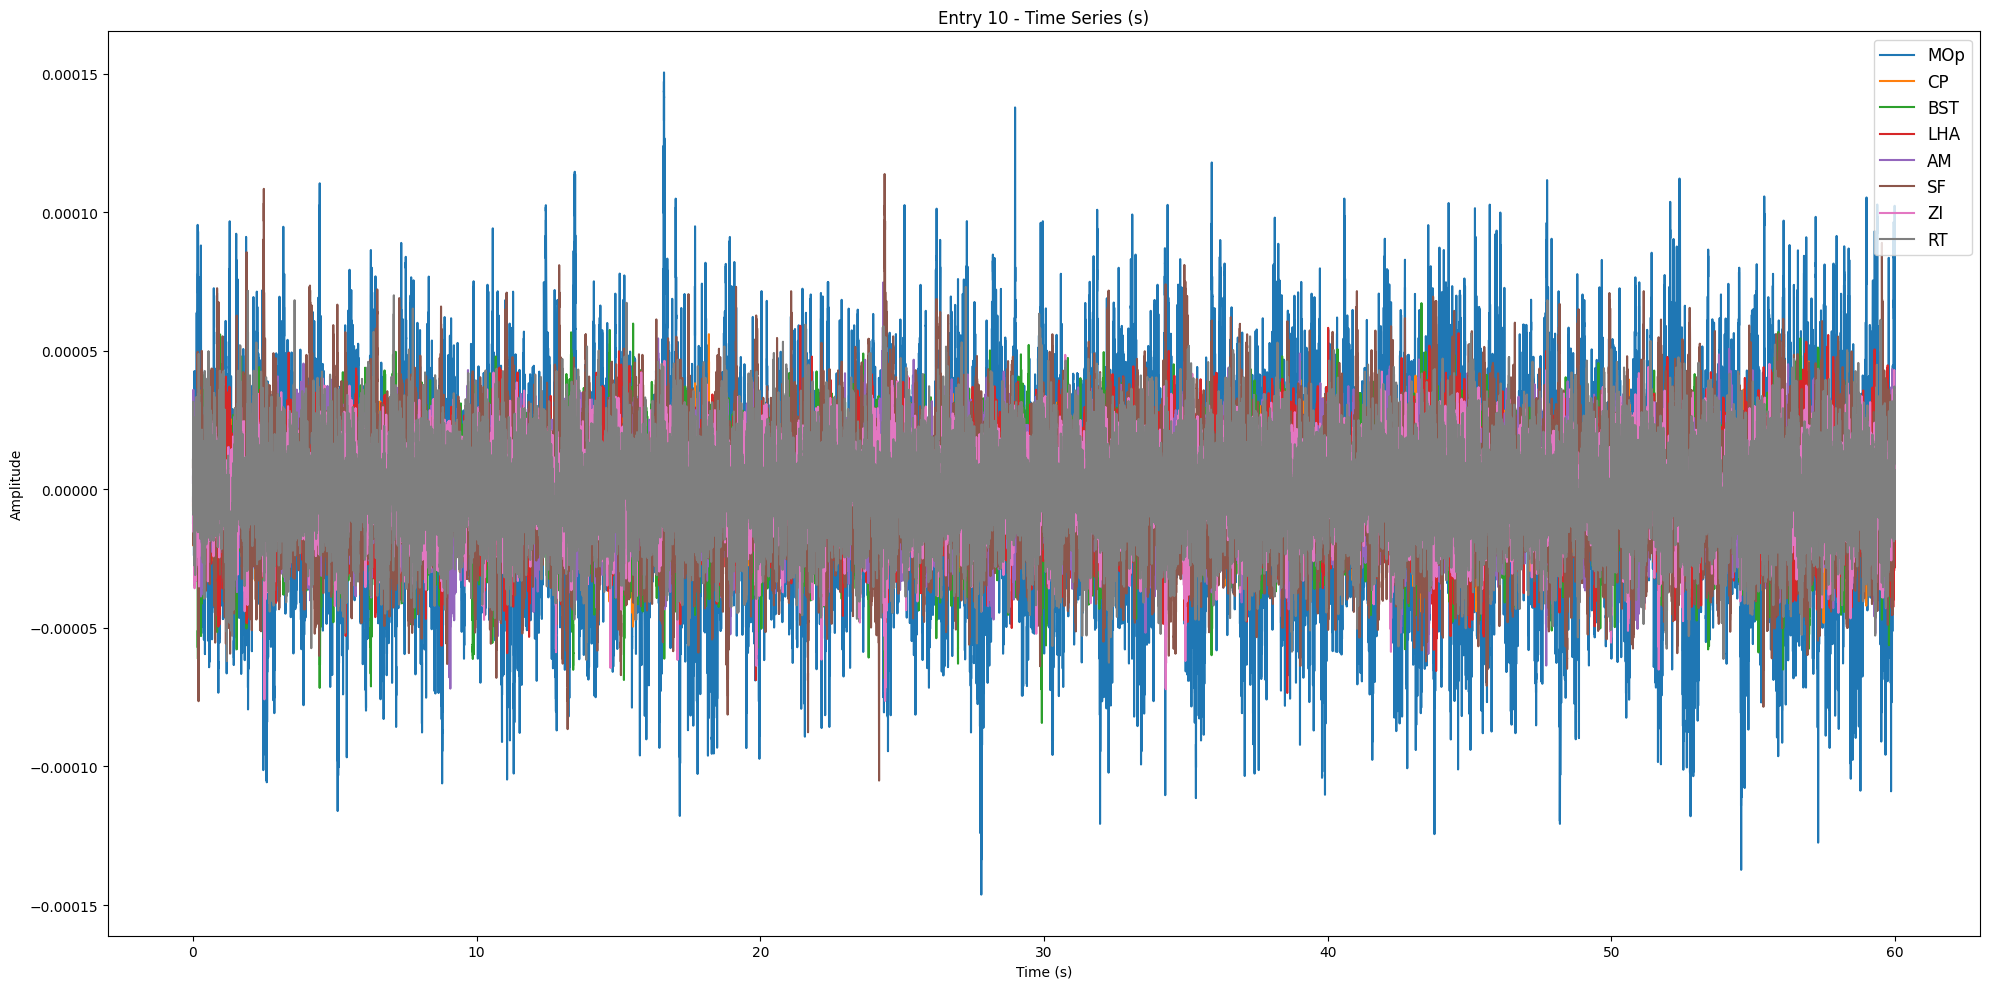

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
# Entry 5 (fifth_lfp / region_labels_5)
# Plot the time series for the fifth entry using its region labels
tenth_lfp = np.array(df['lfp_data'][9])
region_labels_10 = df['acronym'][9] if isinstance(df['acronym'][9], (list, tuple, np.ndarray)) else [df['acronym'][9]]

#plot_lfp_seconds(tenth_lfp, region_labels=region_labels_10, sfreq=2500, title='Entry 10 - Time Series (s)', save_name="Tenth_lfp_time_series.png")
plot_lfp_seconds(tenth_lfp, region_labels=region_labels_10, sfreq=2500, title='Entry 10 - Time Series (s)')

FC matrix shape: (8, 8)


MOp        CP       BST       LHA        AM        SF        ZI  \
MOp  1.000000 -0.124058 -0.393137  0.206931 -0.196852 -0.000612  0.228825   
CP  -0.124058  1.000000 -0.745212 -0.234341 -0.094041  0.539943 -0.109482   
BST -0.393137 -0.745212  1.000000  0.124295  0.178458 -0.540298  0.034245   
LHA  0.206931 -0.234341  0.124295  1.000000 -0.404838 -0.524017  0.176284   
AM  -0.196852 -0.094041  0.178458 -0.404838  1.000000 -0.129995 -0.248036   
SF  -0.000612  0.539943 -0.540298 -0.524017 -0.129995  1.000000 -0.256860   
ZI   0.228825 -0.109482  0.034245  0.176284 -0.248036 -0.256860  1.000000   
RT  -0.014988 -0.091613  0.100920 -0.219379  0.258686 -0.239143  0.171385   

           RT  
MOp -0.014988  
CP  -0.091613  
BST  0.100920  
LHA -0.219379  
AM   0.258686  
SF  -0.239143  
ZI   0.171385  
RT   1.000000

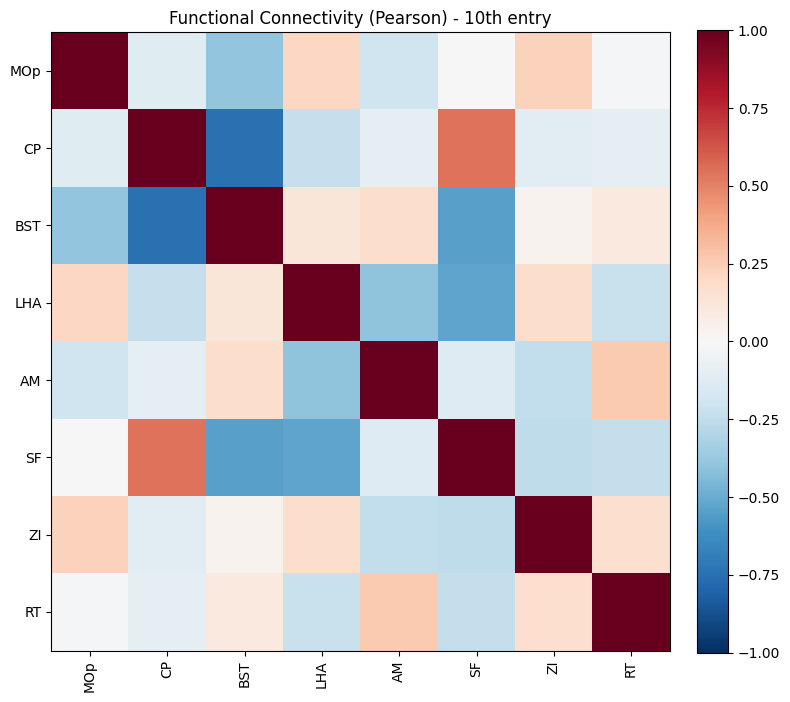

In [25]:
# Calculate Pearson FC matrix from fifth_lfp (structure: time x regions)
labels = list(region_labels_10)
lfp_tenth = np.array(tenth_lfp)  # ensure ndarray


# Pearson correlation across regions
fc = np.corrcoef(lfp_tenth, rowvar=False)
fc_df = pd.DataFrame(fc, index=labels, columns=labels)

print('FC matrix shape:', fc_df.shape)
display(fc_df)

# Plot heatmap
plt.figure(figsize=(8, 8))
im = plt.imshow(fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Functional Connectivity (Pearson) - 10th entry')
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.savefig('Tenth_lfp_FC_matrix.png', dpi=300)
plt.show()

Entry 9: LFP shape (channels x samples): 8 x 149999
Expected samples for 60s at 2500 Hz: 150000 (actual: 149999)
NaN counts per channel (first 10): [0 0 0 0 0 0 0 0]
Computed 55 FC windows


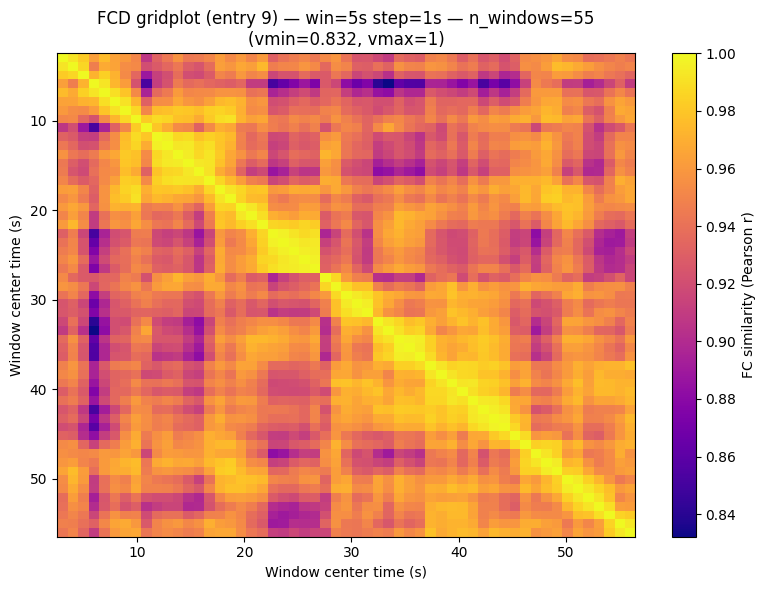

In [45]:
# Apply the compute_and_plot_fcd function to the 5th dataset (index 4)
# This will compute sliding-window FC, show the FCD heatmap, and return results in res_entry5
#res_entry10 = compute_and_plot_fcd(9, df, sfreq=2500, win_sec=5, step_sec=1, symmetric_scale=False, verbose=True, save_name="Tenth_lfp_FCD_matrix.png")
res_entry10 = compute_and_plot_fcd(9, df, sfreq=2500, win_sec=5, step_sec=1, symmetric_scale=False, verbose=True)



## MOP, MOs & CP
### ENTRY 14

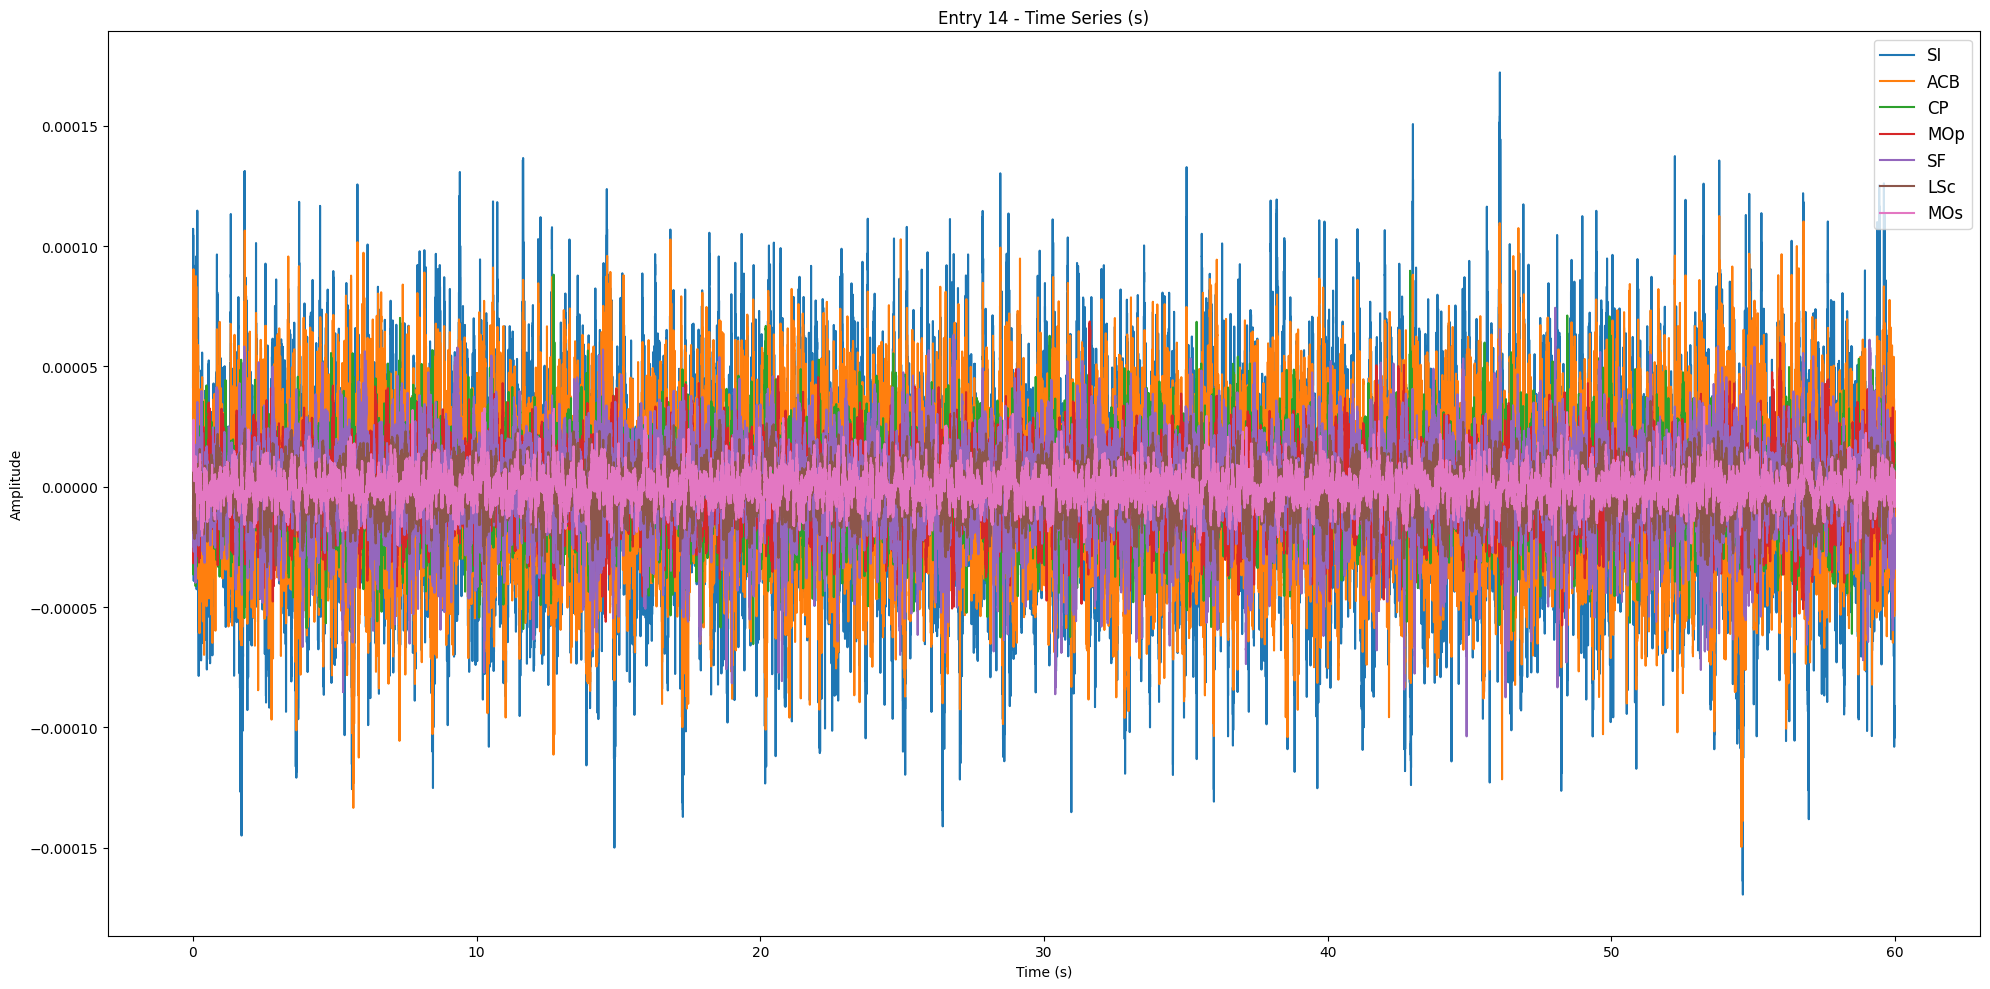

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [26]:
# Plot the time series for the fifth entry using its region labels
# Plot the time series for the fourteenth entry using its region labels
fourteenth_lfp = np.array(df['lfp_data'][13])
region_labels_14 = df['acronym'][13] if isinstance(df['acronym'][13], (list, tuple, np.ndarray)) else [df['acronym'][13]]

#plot_lfp_seconds(fourteenth_lfp, region_labels=region_labels_14, sfreq=2500, title='Entry 14 - Time Series (s)', save_name='Fourteenth_lfp_time_series.png')
plot_lfp_seconds(fourteenth_lfp, region_labels=region_labels_14, sfreq=2500, title='Entry 14 - Time Series (s)')

FC matrix shape: (7, 7)


SI       ACB        CP       MOp        SF       LSc       MOs
SI   1.000000  0.643211 -0.691732 -0.020588  0.169771  0.028465 -0.149042
ACB  0.643211  1.000000 -0.772065 -0.086447  0.190375  0.082153 -0.101493
CP  -0.691732 -0.772065  1.000000  0.053637 -0.185228 -0.054720  0.124596
MOp -0.020588 -0.086447  0.053637  1.000000 -0.400588 -0.657981 -0.287579
SF   0.169771  0.190375 -0.185228 -0.400588  1.000000  0.484454 -0.515757
LSc  0.028465  0.082153 -0.054720 -0.657981  0.484454  1.000000  0.028800
MOs -0.149042 -0.101493  0.124596 -0.287579 -0.515757  0.028800  1.000000

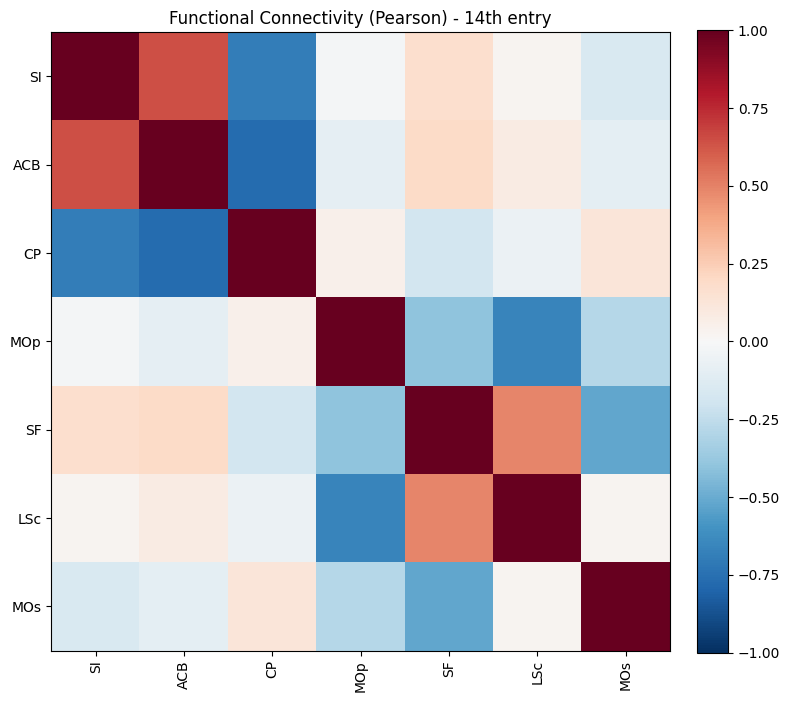

In [27]:
# Calculate Pearson FC matrix from fifth_lfp (structure: time x regions)
labels_14 = list(region_labels_14)
lfp_fourteenth = np.array(fourteenth_lfp)  # ensure ndarray

# Pearson correlation across regions
fc = np.corrcoef(lfp_fourteenth, rowvar=False)
fc_df = pd.DataFrame(fc, index=labels_14, columns=labels_14)

print('FC matrix shape:', fc_df.shape)
display(fc_df)

# Plot heatmap
plt.figure(figsize=(8, 8))
im = plt.imshow(fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Functional Connectivity (Pearson) - 14th entry')
plt.xticks(range(len(labels_14)), labels_14, rotation=90)
plt.yticks(range(len(labels_14)), labels_14)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.savefig('Fourteenth_lfp_FC_matrix.png', dpi=300)
plt.show()

Entry 13: LFP shape (channels x samples): 7 x 149999
Expected samples for 60s at 2500 Hz: 150000 (actual: 149999)
NaN counts per channel (first 10): [0 0 0 0 0 0 0]
Computed 55 FC windows
Saved FCD figure to Fourteenth_lfp_FCD_matrix.png


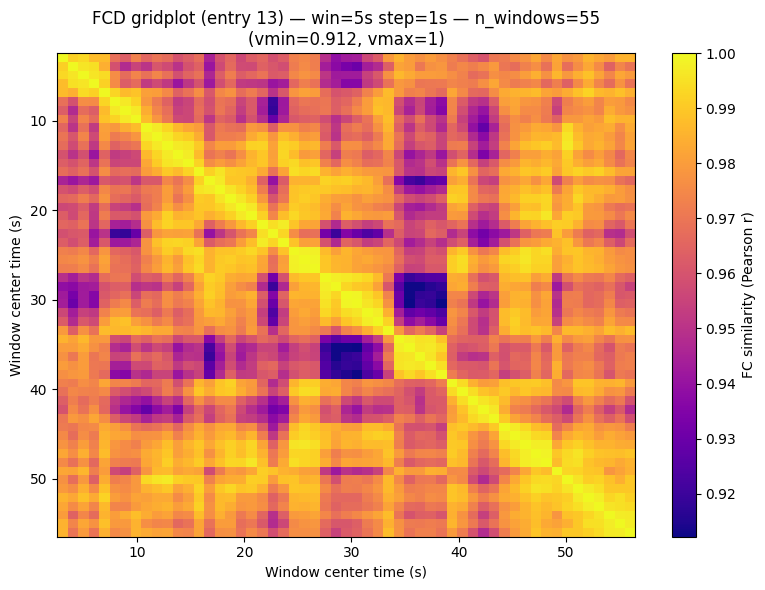

Entry 13: LFP shape (channels x samples): 7 x 149999
Expected samples for 60s at 2500 Hz: 150000 (actual: 149999)
NaN counts per channel (first 10): [0 0 0 0 0 0 0]
Computed 55 FC windows


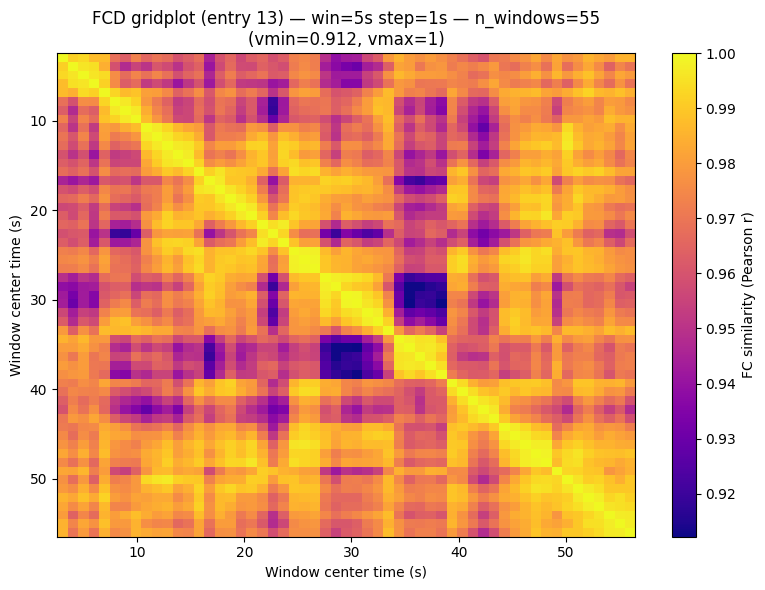

In [ ]:
# FCD for the fourteenth dataset (entry 14)
# Apply the compute_and_plot_fcd function to the 14th dataset (index 13)
# This will compute sliding-window FC, show the FCD heatmap, and return results in res_entry14
#res_entry14 = compute_and_plot_fcd(13, df, sfreq=2500, win_sec=5, step_sec=1, symmetric_scale=False, verbose=True, save_name="Fourteenth_lfp_FCD_matrix.png")
res_entry14 = compute_and_plot_fcd(13, df, sfreq=2500, win_sec=5, step_sec=1, symmetric_scale=False, verbose=True)



## MOp (Primary), MOs (Secondary), & CP

### Entry 22 and 23 --> Have less regions

### Entry 22

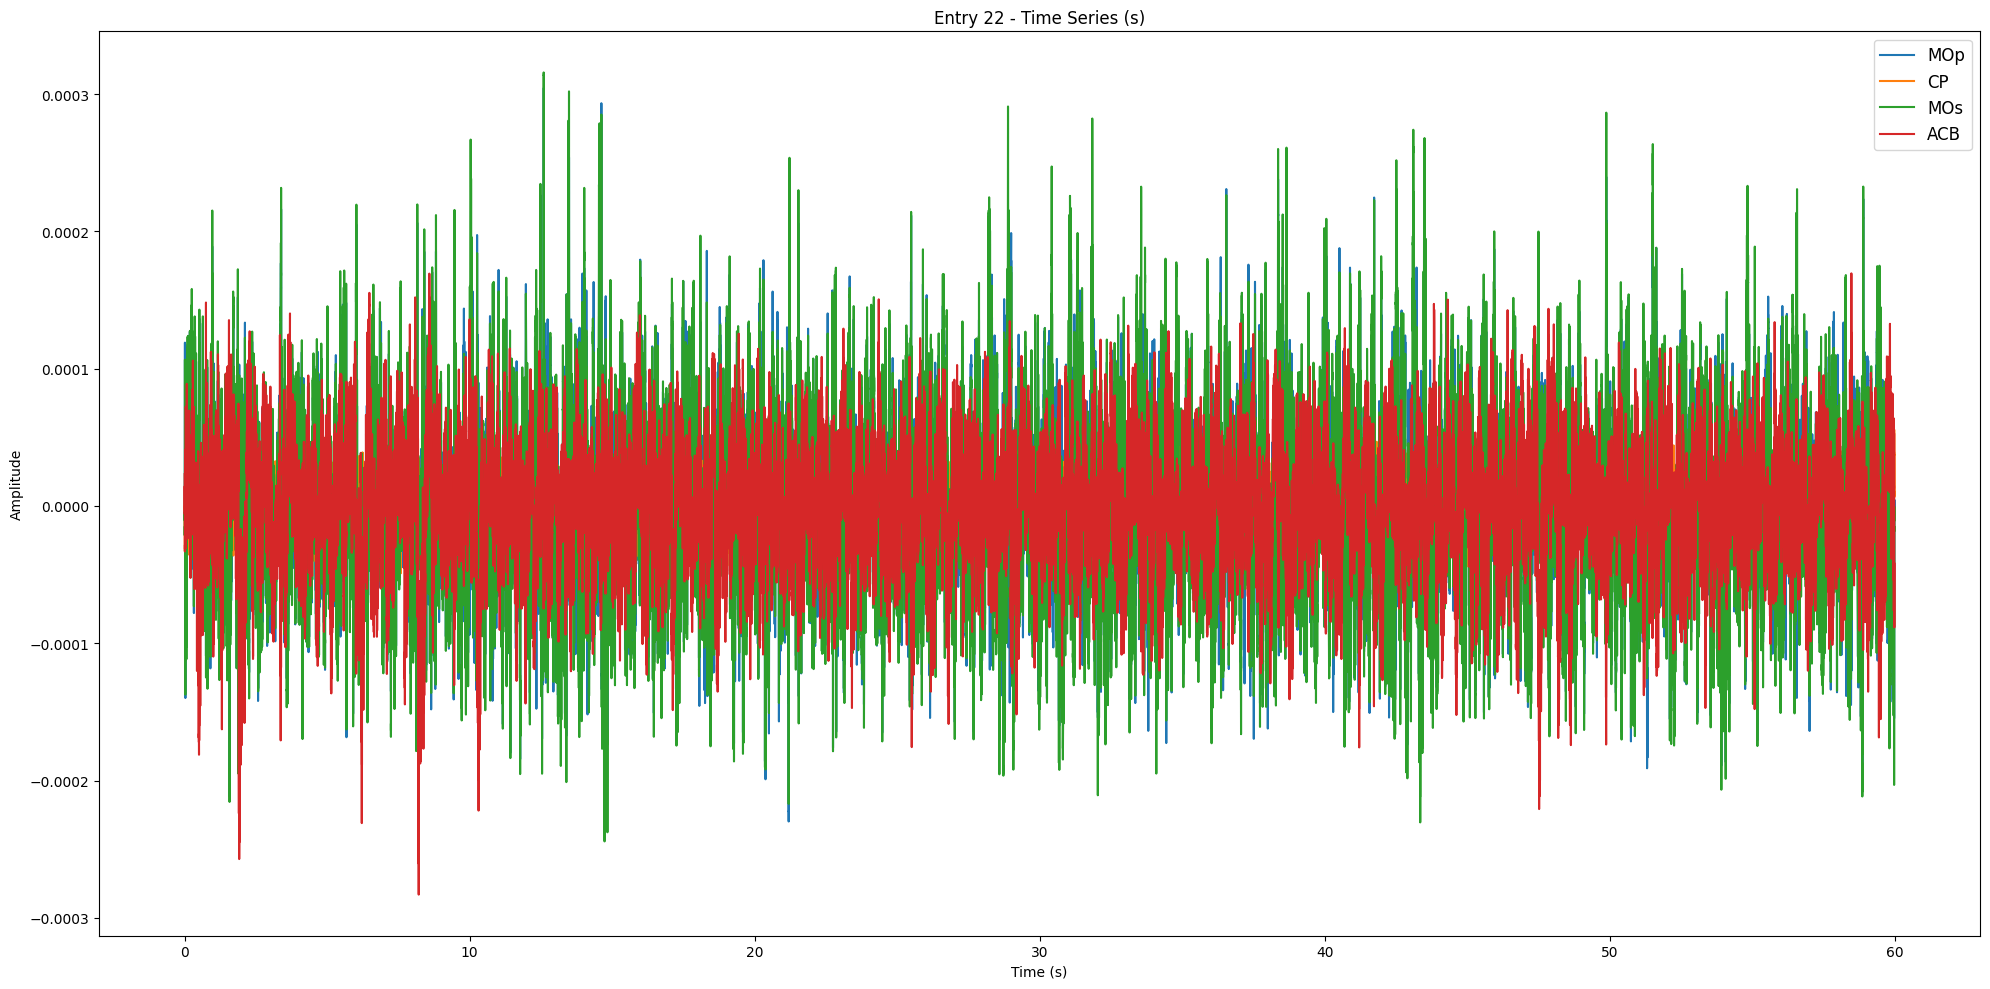

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot the time series for the twenty-second entry using its region labels
twentysecond_lfp = np.array(df['lfp_data'][21])
region_labels_22 = df['acronym'][21] if isinstance(df['acronym'][21], (list, tuple, np.ndarray)) else [df['acronym'][21]]

#plot_lfp_seconds(twentysecond_lfp, region_labels=region_labels_22, sfreq=2500, title='Entry 22 - Time Series (s)', save_name='Twentysecond_lfp_time_series.png')
plot_lfp_seconds(twentysecond_lfp, region_labels=region_labels_22, sfreq=2500, title='Entry 22 - Time Series (s)')

FC matrix shape: (4, 4)


MOp        CP       MOs       ACB
MOp  1.000000 -0.454596  0.895784 -0.394973
CP  -0.454596  1.000000 -0.444720 -0.143128
MOs  0.895784 -0.444720  1.000000 -0.305057
ACB -0.394973 -0.143128 -0.305057  1.000000

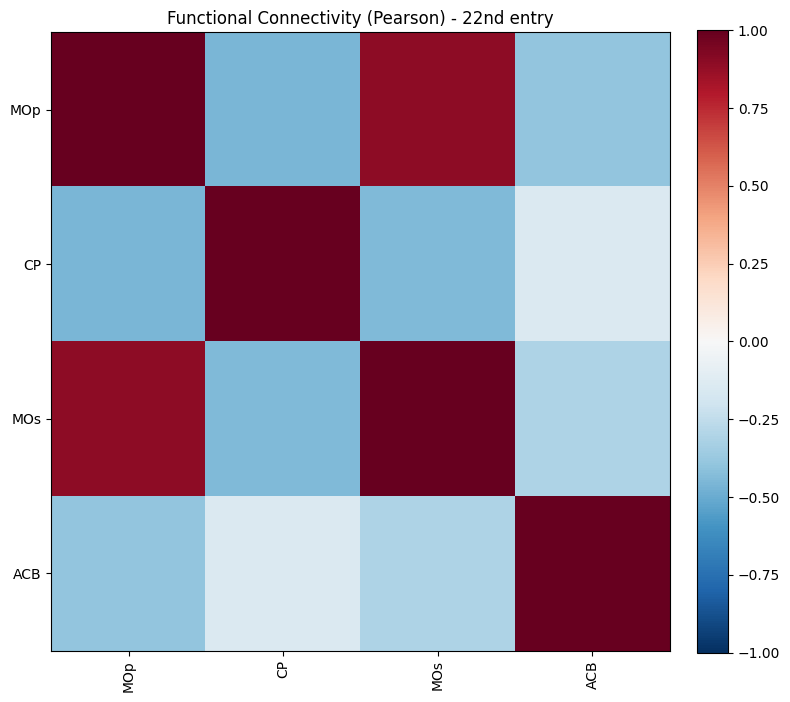

In [29]:
# Calculate Pearson FC matrix from fifth_lfp (structure: time x regions)
labels_22 = list(region_labels_22)
lfp_twentysecond = np.array(twentysecond_lfp)  # ensure ndarray

# Pearson correlation across regions
fc = np.corrcoef(lfp_twentysecond, rowvar=False)
fc_df = pd.DataFrame(fc, index=labels_22, columns=labels_22)

print('FC matrix shape:', fc_df.shape)
display(fc_df)

# Plot heatmap
plt.figure(figsize=(8, 8))
im = plt.imshow(fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Functional Connectivity (Pearson) - 22nd entry')
plt.xticks(range(len(labels_22)), labels_22, rotation=90)
plt.yticks(range(len(labels_22)), labels_22)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.savefig('Twentysecond_lfp_FC_matrix.png', dpi=300)
plt.show()

Entry 21: LFP shape (channels x samples): 4 x 149999
Expected samples for 60s at 2500 Hz: 150000 (actual: 149999)
NaN counts per channel (first 10): [0 0 0 0]
Computed 55 FC windows
Saved FCD figure to Twenty_Second_lfp_FCD_matrix.png


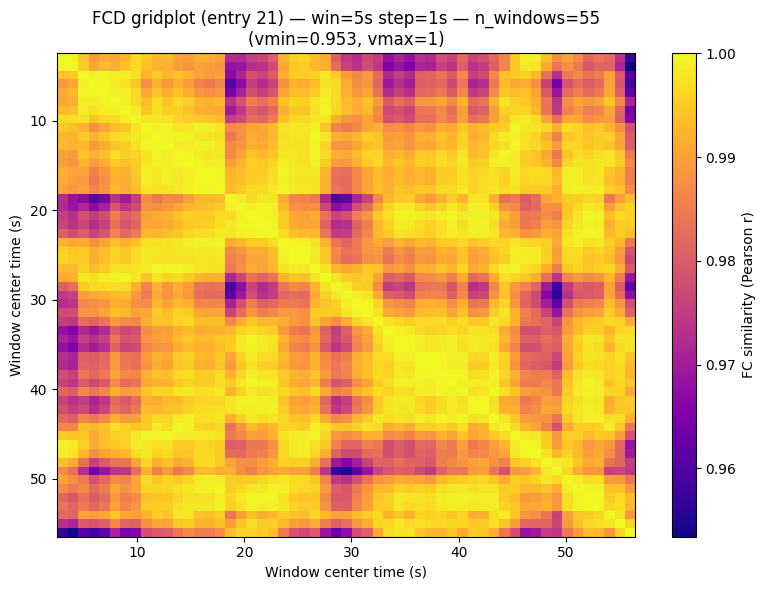

In [ ]:
# FCD for the 22 dataset (entry 22)

#res_entry22 = compute_and_plot_fcd(21, df, sfreq=2500, win_sec=5, step_sec=1, symmetric_scale=False, verbose=True, save_name="Twenty_Second_lfp_FCD_matrix.png")
res_entry22 = compute_and_plot_fcd(21, df, sfreq=2500, win_sec=5, step_sec=1, symmetric_scale=False, verbose=True)



### Entry 23

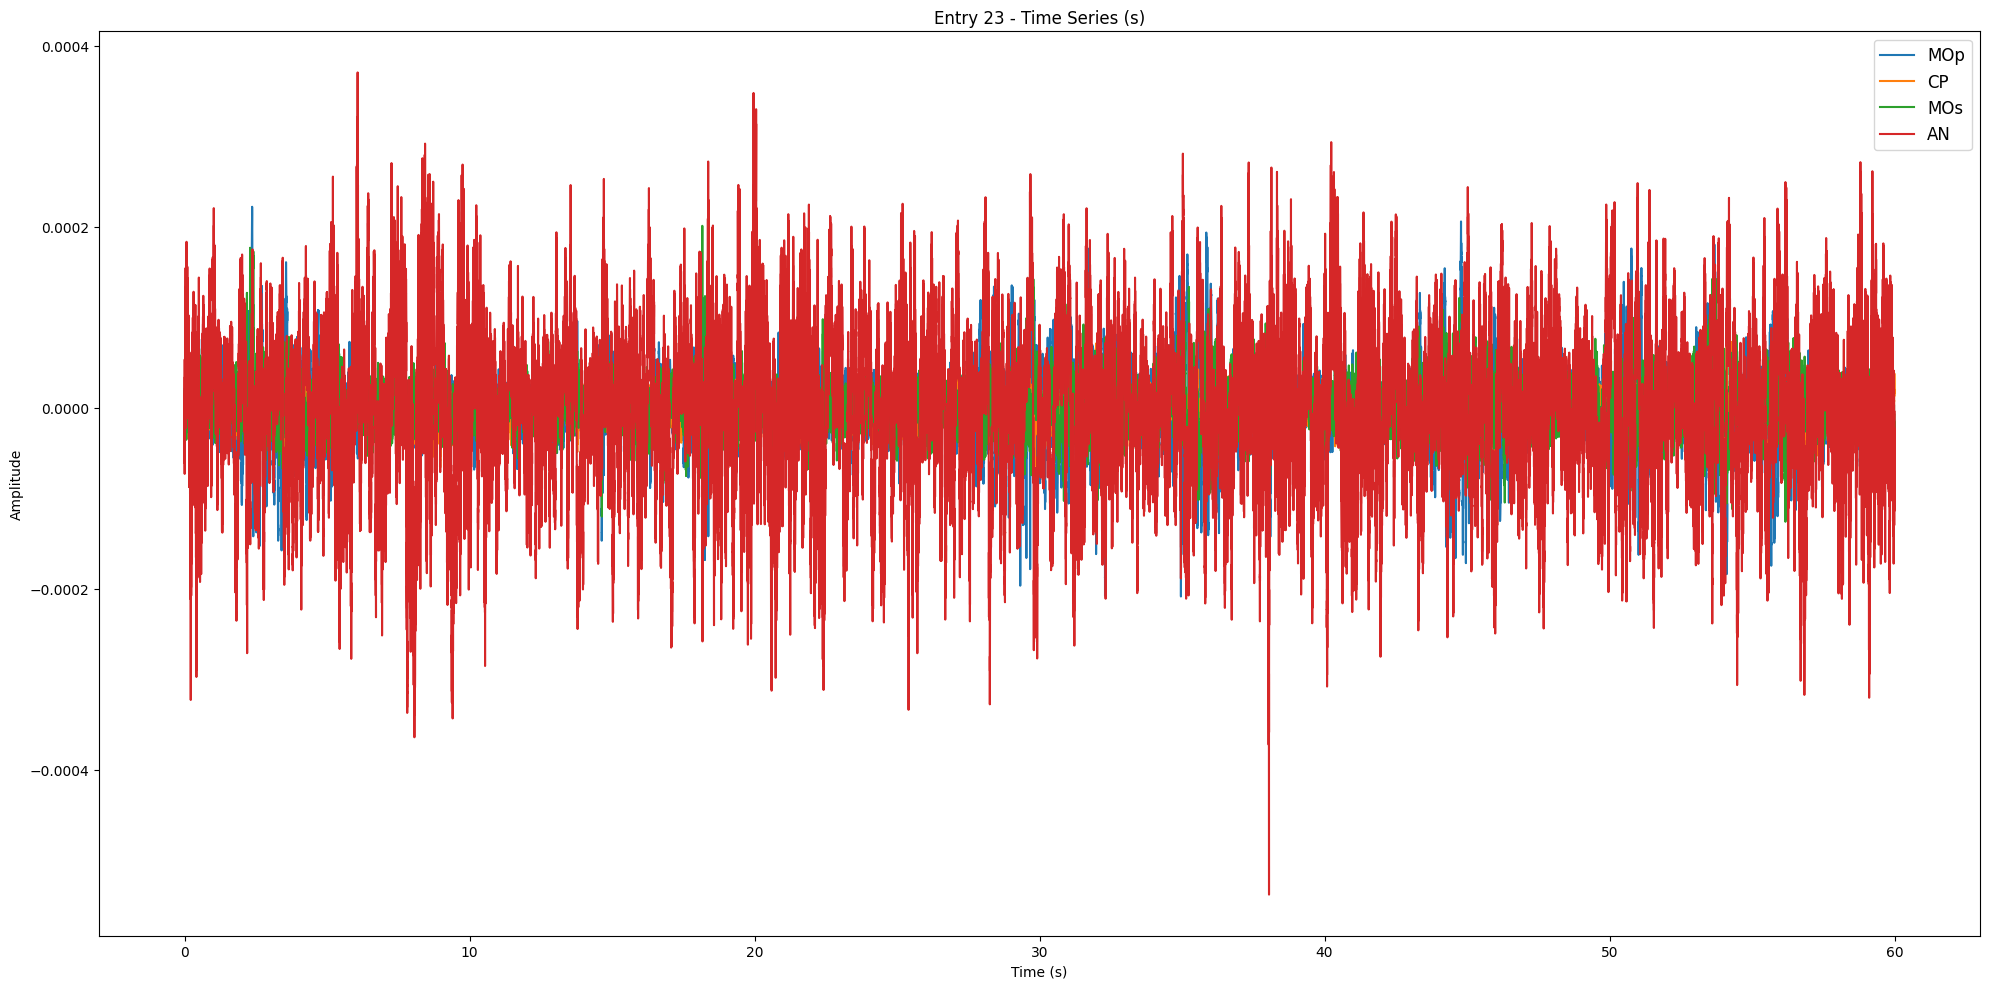

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [30]:
# Plot the time series for the twenty-third entry using its region labels
twentythird_lfp = np.array(df['lfp_data'][22])
region_labels_23 = df['acronym'][22] if isinstance(df['acronym'][22], (list, tuple, np.ndarray)) else [df['acronym'][22]]

#plot_lfp_seconds(twentythird_lfp, region_labels=region_labels_23, sfreq=2500, title='Entry 23 - Time Series (s)', save_name='Twentythird_lfp_time_series.png')
plot_lfp_seconds(twentythird_lfp, region_labels=region_labels_23, sfreq=2500, title='Entry 23 - Time Series (s)')

FC matrix shape: (4, 4)


MOp        CP       MOs        AN
MOp  1.000000 -0.626632 -0.089204 -0.126467
CP  -0.626632  1.000000 -0.322040  0.347904
MOs -0.089204 -0.322040  1.000000 -0.243536
AN  -0.126467  0.347904 -0.243536  1.000000

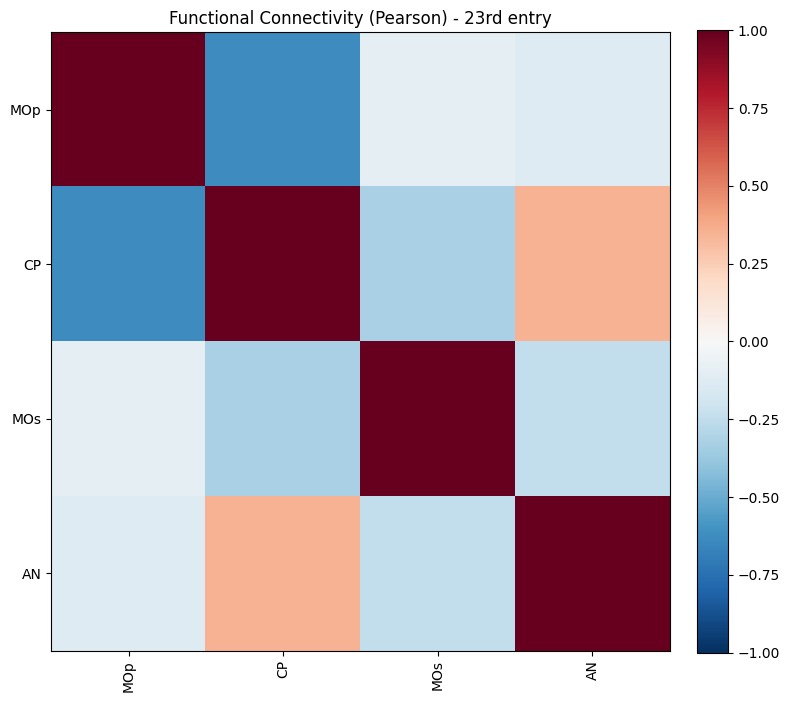

In [31]:
# Calculate Pearson FC matrix from fifth_lfp (structure: time x regions)
labels_23 = list(region_labels_23)
lfp_twentythird = np.array(twentythird_lfp)  # ensure ndarray

# Pearson correlation across regions
fc = np.corrcoef(lfp_twentythird, rowvar=False)
fc_df = pd.DataFrame(fc, index=labels_23, columns=labels_23)

print('FC matrix shape:', fc_df.shape)
display(fc_df)

# Plot heatmap
plt.figure(figsize=(8, 8))
im = plt.imshow(fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Functional Connectivity (Pearson) - 23rd entry')
plt.xticks(range(len(labels_23)), labels_23, rotation=90)
plt.yticks(range(len(labels_23)), labels_23)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.savefig('Twentythird_lfp_FC_matrix.png', dpi=300)
plt.show()

Entry 22: LFP shape (channels x samples): 4 x 149999
Expected samples for 60s at 2500 Hz: 150000 (actual: 149999)
NaN counts per channel (first 10): [0 0 0 0]
Computed 55 FC windows


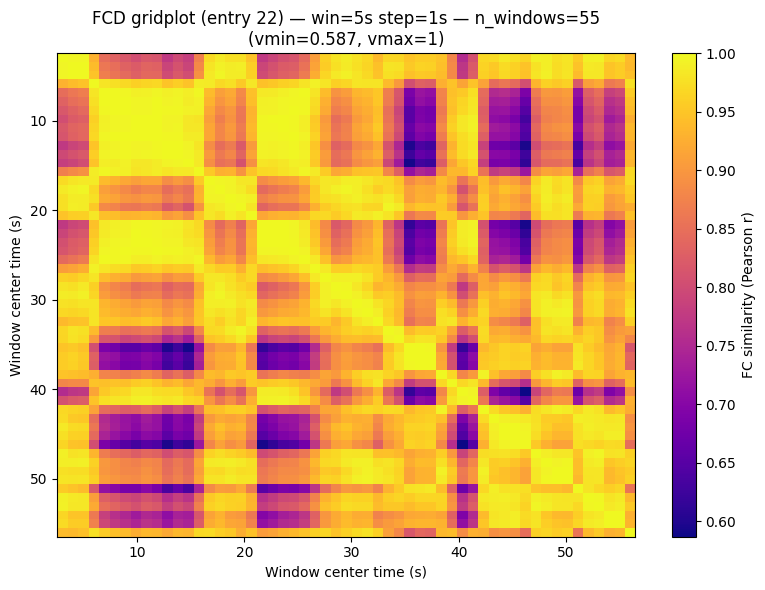

In [49]:
# FCD for the 23 dataset

#res_entry23 = compute_and_plot_fcd(22, df, sfreq=2500, win_sec=5, step_sec=1, symmetric_scale=False, verbose=True, save_name="Twenty_Third_lfp_FCD_matrix.png")
res_entry23 = compute_and_plot_fcd(22, df, sfreq=2500, win_sec=5, step_sec=1, symmetric_scale=False, verbose=True)

